# Use Case: Creating a Coding Agent


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/partners/galileo/ai_hallucination_detection_and_reduction.ipynb)

[![AI Learning Hub](https://img.shields.io/badge/AI%20Learning%20Hub-Click%20Here-blue)](https://www.mongodb.com/resources/use-cases/artificial-intelligence?utm_campaign=ai_learning_hub&utm_source=github&utm_medium=referral)

**Primary Objective:**
Create an intelligent coding agent that can analyze GitHub repositories and assist with code-related tasks.

This system is built to improve developer productivity focusing on the following example scenarios:
1. Code discovery and navigation
2. Repository ingestion
3. Automated unit test creation


**Components:**
- Gitingest: Converts GitHub repositories into structured markdown format for processing and analysis
- VoyageAI - Generates high-quality code-specific embeddings using the voyage-code-3 model for semantic search
- OpenAI - Powers text generation via GPT-4.1
- PyMongo - Manages MongoDB connections and operations for storing codebase metadata, files, and embeddings
- Galileo - Monitors and evaluates AI responses for hallucination detection and quality assessment metrics
- LangGraph - Orchestrates complex agent workflows and manages state transitions for multi-step coding tasks


**This notebook contains three main parts:**

- Part 1: Data Ingestion, Preparation and Storage
- Part 2: Information Retrieval and RAG
- Part 3: Coding Agent

**What you will learn**
- ‚úÖ Building production-ready RAG systems
- ‚úÖ Implementing advanced vector search strategies
- ‚úÖ Creating AI-powered coding assistants
- ‚úÖ Establishing comprehensive AI monitoring
- ‚úÖ Designing agentic workflows with tool integration
- ‚úÖ Evaluating and improving AI system quality

**Key topics explored:** Multi-modal RAG architecture, MongoDB Atlas vector search, embeddings, hybrid search with RankFusion, AI hallucination detection using Galileo, agentic workflows with LangGraph, GitHub repository processing with GitIngest, quality evaluation frameworks, tool development and integration, and production-ready AI observability patterns.

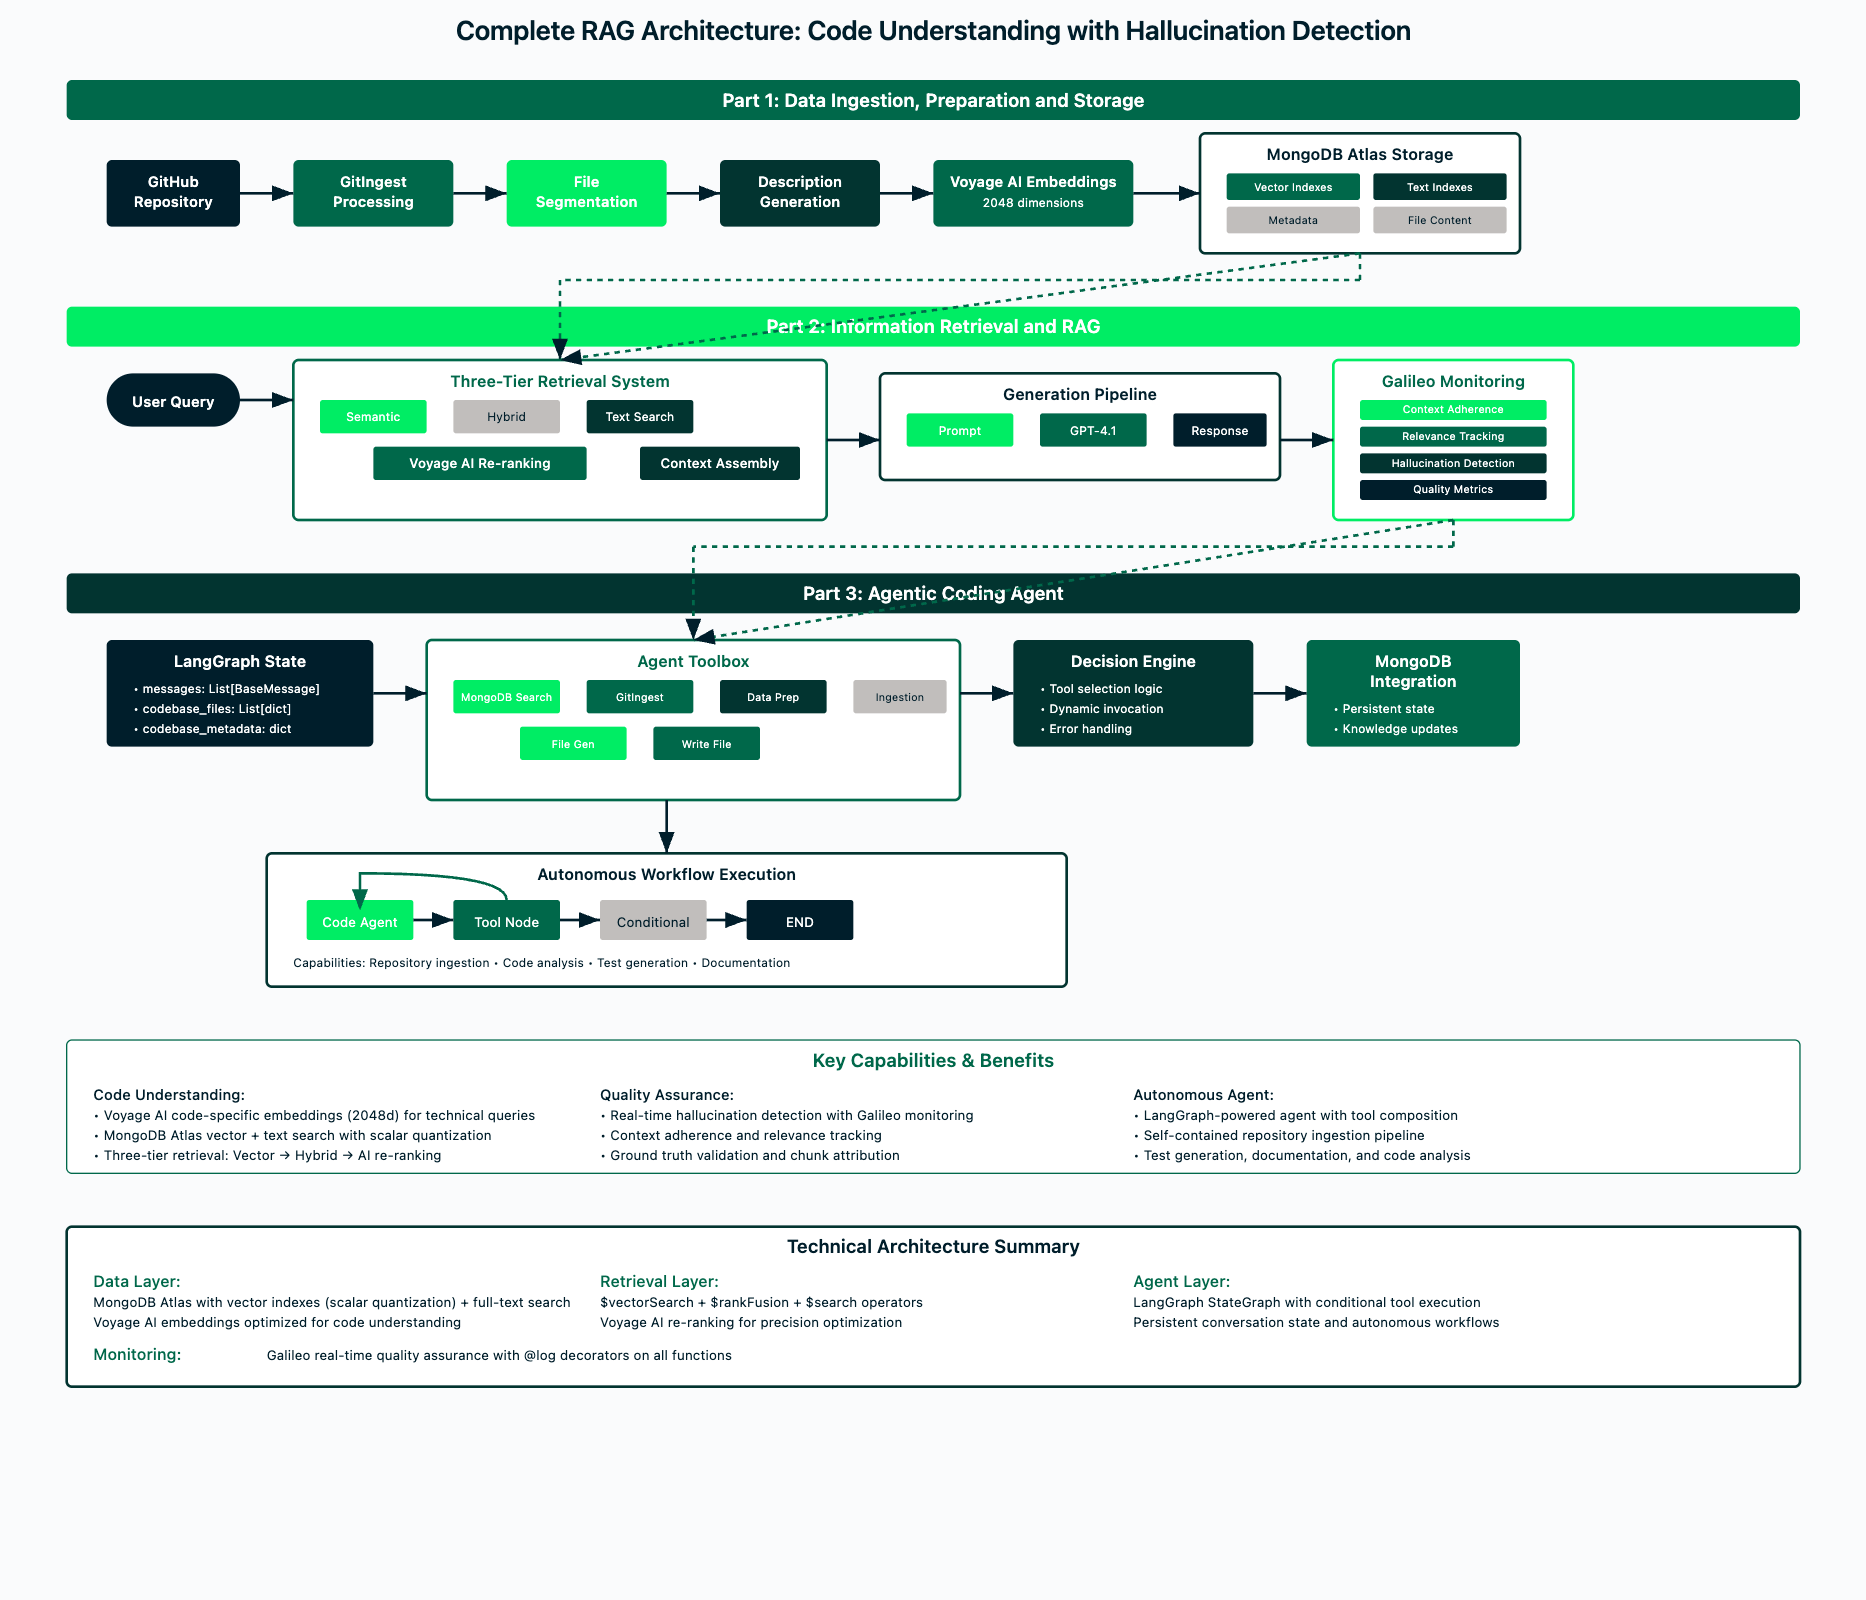

# Setup: Intalling Packages and Environment Variables

In [1]:
! pip install -qU gitingest voyageai openai pymongo "galileo[openai]" langgraph-checkpoint-mongodb langgraph langchain pandas langchain-openai matplotlib

In [2]:
import getpass
import os


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

This code configures Galileo's AI monitoring platform for tracking system performance and detecting hallucinations.
Get your Galileo API Key here:

In [3]:
set_env_securely("GALILEO_API_KEY", "Enter your Galileo API key: ")

Securely captures and stores the Galileo API key using masked input (like password entry)
- GALILEO_PROJECT: Organizes AI experiments under a project container
- GALILEO_LOG_STREAM: Categorizes logs within the project for different experiment types

Once configured, Galileo automatically tracks retrieval quality, hallucination rates, and AI response accuracy when functions are decorated with @log(). This provides enterprise-grade monitoring without building custom evaluation infrastructure, essential for reliable production AI applications.

In [4]:
# Optional, set a default Project
os.environ["GALILEO_PROJECT"] = "TEST"

# Optional, set a default Log Stream
os.environ["GALILEO_LOG_STREAM"] = "TEST_LOGS"

# Part 1: Data Ingestion, Preparation and Storage

Part 1: Data Ingestion Process Overview

**The data ingestion pipeline transforms raw GitHub repositories into a searchable, AI-ready knowledge base through four key stages:**

**1. Repository Extraction**
- **GitIngest** processes the GitHub URL and extracts the entire codebase structure
- Analyzes repository tree, file relationships, and content hierarchy
- Converts source code into structured, processable format

**2. Intelligent Segmentation**
- **File-level chunking** breaks down the codebase into manageable pieces
- **Content parsing** identifies code structure, functions, classes, and documentation
- **Smart boundaries** ensure logical code blocks remain intact

**3. AI-Powered Description Generation**
- **Context-aware summaries** created for each file using AI
- **Code understanding** generates human-readable descriptions of what each file does
- **Semantic enrichment** adds searchable metadata beyond just raw code

**4. Code-Specific Embeddings**
- **Voyage AI embeddings (2048d)**: Code-optimized vector representations for technical searches
- **Specialized models** trained specifically for understanding code semantics and structure
- **Enhanced retrieval** for programming-related queries and code comprehension

**5. MongoDB Atlas Storage**
- **Vector indexes** with scalar quantization for efficient similarity search
- **Text indexes** for keyword-based searches
- **Dual collections**: Metadata and file content stored separately for optimal performance

**Result**: A GitHub repository becomes a fully searchable, semantically-understood knowledge base ready for sophisticated RAG queries, with both vector similarity and traditional text search capabilities optimized for code understanding.

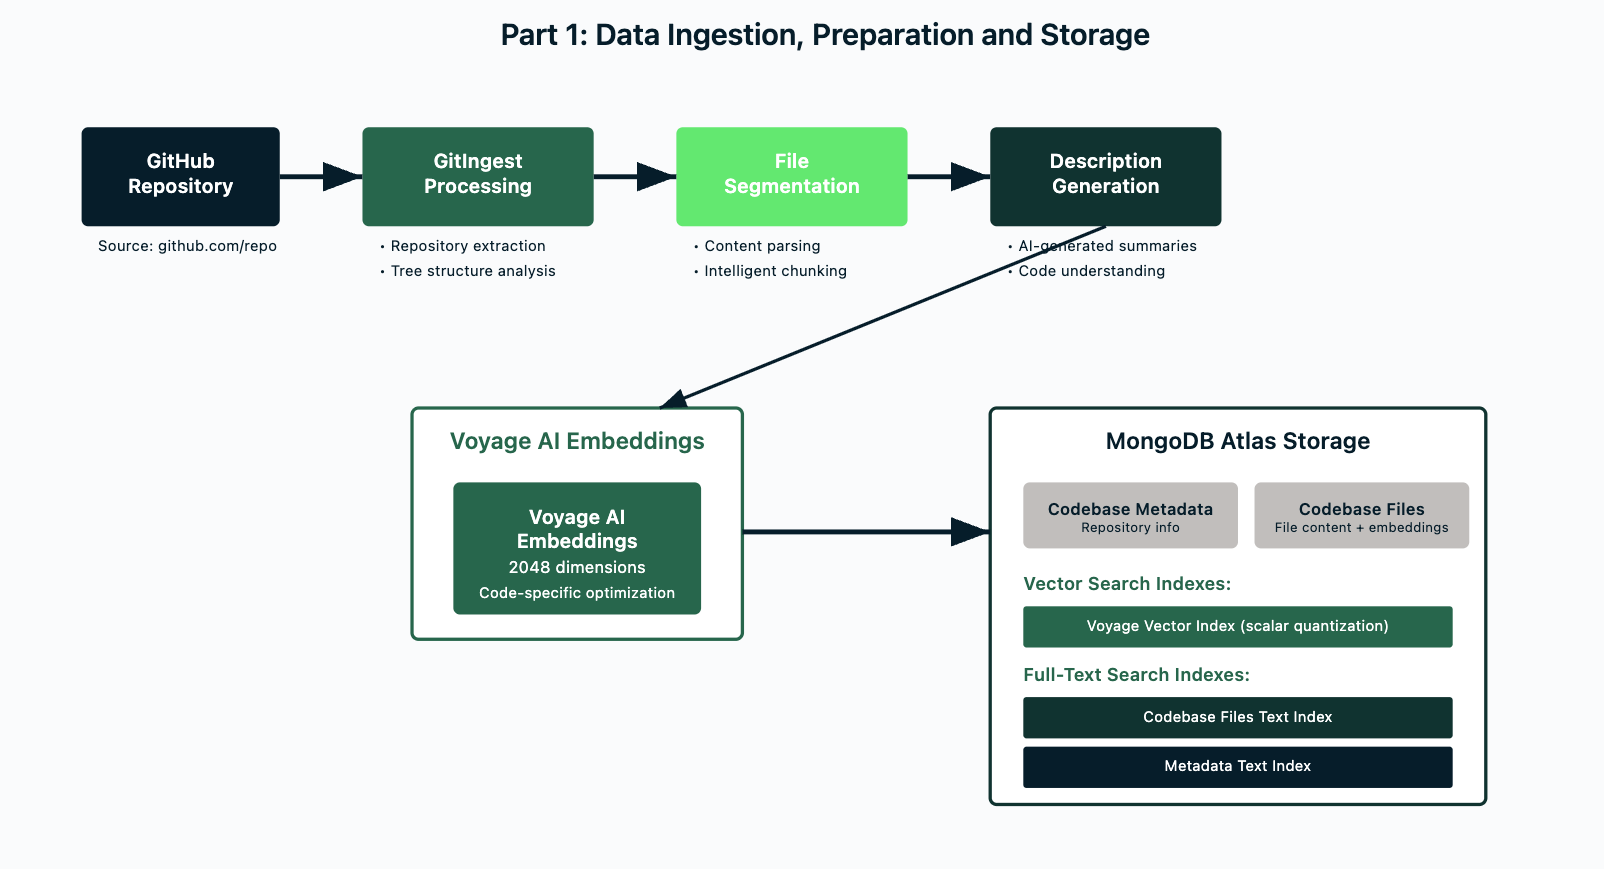

## 1.1 Repository Extraction

The ```codebase_metadata``` dictionary serves as a repository-level data container that captures high-level information about the entire GitHub repository being processed:

Example of what an object can look like below:

```
codebase_metadata = {
    "url": "https://github.com/RichmondAlake/memorizz",
    "repository": "richmondalake/memorizz",
    "analyzed_count": "57",              # Number of files processed
    "estimated_tokens": "101.0k",        # Total token count
    "tree": "Directory structure...",     # Full directory tree
    "description": "AI-generated repo summary...",
    "voyage_embeddings": [0.3, 0.4, ...]
}
````


In [5]:
codebase_metadata = {}

Provide the url of the codebase you want to process.
You can change the URL below for any url of your choice

In [6]:
codebase_metadata["url"] = "https://github.com/RichmondAlake/memorizz"

GitIngest is a specialized tool that converts GitHub repositories into structured markdown format for AI processing. The ingest_async function is its asynchronous interface.

Without GitIngest, developers would need to manually clone repos, parse file structures, and format content - GitIngest automates this entire pipeline into a single async function call.

In [7]:
from gitingest import ingest_async

summary, tree, content = await ingest_async(codebase_metadata.get("url"))

In [8]:
print(summary)

Repository: richmondalake/memorizz
Files analyzed: 59

Estimated tokens: 111.1k


In [9]:
attrs = {}
for line in summary.splitlines():
    line = line.strip()
    if not line or ":" not in line:
        continue
    key, val = line.split(":", 1)
    attrs[key.lower().replace(" ", "_")] = val.strip()

In [10]:
codebase_metadata["repository"] = attrs.get("repository")
codebase_metadata["analyzed_count"] = attrs.get("files_analyzed")
codebase_metadata["estimated_tokens"] = attrs.get("estimated_tokens")

In [11]:
import pprint

pprint.pprint(codebase_metadata)

{'analyzed_count': '59',
 'estimated_tokens': '111.1k',
 'repository': 'richmondalake/memorizz',
 'url': 'https://github.com/RichmondAlake/memorizz'}


In [12]:
codebase_metadata["tree"] = tree

In [ ]:
print(codebase_metadata["tree"])

## 1.2 Intelligent Segmentation

In [14]:
set_env_securely("OPENAI_API_KEY", "Enter your OPENAI_API_KEY: ")

This code below imports Galileo's instrumented version of the OpenAI client and context manager:

```python
from galileo.openai import openai, galileo_context
```

This line **imports Galileo's instrumented version of the OpenAI client** and context manager:

**What it imports:**

1. **`openai`**: A **wrapped OpenAI client** that automatically logs all API calls to Galileo
   - Replaces the standard `import openai`
   - Every API call (completions, embeddings, etc.) is automatically monitored
   - Captures tokens used, response times, model performance metrics

2. **`galileo_context`**: A **context manager** for controlling when logging happens
   - Used to flush logs to Galileo's servers: `galileo_context.flush()`
   - Manages logging sessions and ensures data is properly uploaded

**Why use this instead of regular OpenAI?**
- **Automatic Monitoring**: No need to manually instrument every API call
- **Hallucination Detection**: Galileo analyzes responses for accuracy and reliability
- **Cost Tracking**: Monitors token usage and API costs across all calls
- **Performance Analytics**: Tracks response times and error rates

This provides **zero-code observability** - just replace the import and get comprehensive AI monitoring.

In [15]:
from typing import Dict

from galileo.openai import galileo_context, openai

openai_client = openai.OpenAI()

The `generate_repo_description` uses AI to automatically write a README-style summary of what a GitHub repository does.

1. Takes in: Repository information (name, URL, file count, directory structure) + a snippet of the actual code
2. Asks GPT-4: "Look at this repo data and write a paragraph explaining what this codebase is for"
3. Returns: An AI-generated description that explains the repository's purpose, structure, and goals


**Why it's useful:**
- Automatic Documentation: No need to manually write repo descriptions
- Consistent Format: Always produces well-structured summaries
- Context Aware: Understands what the code actually does by analyzing the content
- Searchable Metadata: Creates text that can be embedded and searched later

In [16]:
def generate_repo_description(
    metadata: Dict[str, str],
    content: str,
    model: str = "gpt-4.1",
    snippet_length: int = 1000,
) -> str:
    """
    Generate a Markdown README-style description of a GitHub repo using the
    OpenAI Response API. The description will:
      - Name the repo and link to it
      - Mention how many files were analyzed and the approximate token count
      - Summarize the high-level directory structure (major folders)
      - Infer the repository's purpose and main goals

    Args:
        metadata: dict with keys:
            - repository: "owner/name"
            - url: repo URL
            - analyzed_count: number of files analyzed (string or int)
            - estimated_tokens: e.g. "101.0k"
            - tree: full directory structure string
        model: which OpenAI model to call (default "gpt-4.1")

    Returns:
        A Markdown-formatted description string.
    """
    # Extract just the top-level entries for brevity
    tree_lines = metadata.get("tree", "").splitlines()
    top_level = "\n".join(tree_lines[:4])  # e.g. the first three indented lines

    prompt = f"""
You are a documentation assistant. Using the metadata and a snippet of the repository's content,
write a concise, engaging README-style paragraph in Markdown that:
- Names the repository and links to it
- Mentions how many files were analyzed and the approximate token count
- Summarizes the high-level directory structure (major folders)
- Infers the repository's purpose and primary goals
- Highlights any notable code patterns or core modules from the provided content snippet


Metadata:
Repository: {metadata.get('repository')}
URL: {metadata.get('url')}
Files analyzed: {metadata.get('analyzed_count')}
Estimated tokens: {metadata.get('estimated_tokens')}

Top-level directory structure:
{top_level}

Content snippet:
{content.strip()[:snippet_length]}

Please produce one well-crafted paragraph.
"""

    response = openai_client.responses.create(model=model, input=prompt)
    return response.output_text.strip()

In [17]:
codebase_metadata["description"] = generate_repo_description(codebase_metadata, content)

In [18]:
pprint.pprint(codebase_metadata["description"])

('[richmondalake/memorizz](https://github.com/RichmondAlake/memorizz) is an '
 'experimental memory management framework for AI agents, created primarily '
 'for educational and research purposes. The repository contains 59 analyzed '
 'files totaling approximately 111,100 tokens, featuring a clear top-level '
 'directory with essential documentation such as `README.md` and '
 '`LICENCE.txt`. MemoRizz‚Äôs high-level structure suggests a modular project '
 'with potential for extension, focused on enabling AI agents to store and '
 'retrieve memories effectively. From the provided README snippet, the repo '
 'emphasizes agent memory mechanisms‚Äîlikely offering core modules for memory '
 'encoding, retrieval, and possibly integration with other agent capabilities. '
 'Notable code patterns and architectural decisions may center around agent '
 'memory abstractions, with the intent to foster experimentation in cognitive '
 'architectures. Please note that MemoRizz is in its early stages,

In [19]:
print(content[0:1000])

FILE: README.md
<div align="center">

# Memorizz üß†

üìä **[Agent Memory Presentation](https://docs.google.com/presentation/d/1iSu667m5-pOXMrJq_LjkfnfD4V0rW1kbhGaQ2u3TKXQ/edit?usp=sharing)** | üé• **[AIEWF Richmond's Talk](https://youtu.be/W2HVdB4Jbjs?si=faaI3cMLc71Efpeu)**

[![PyPI version](https://badge.fury.io/py/memorizz.svg)](https://badge.fury.io/py/memorizz)
[![PyPI downloads](https://img.shields.io/pypi/dm/memorizz.svg)](https://pypistats.org/packages/memorizz)

</div>

> **‚ö†Ô∏è IMPORTANT WARNING ‚ö†Ô∏è**
> 
> **MemoRizz is an EXPERIMENTAL library intended for EDUCATIONAL PURPOSES ONLY.**
> 
> **Do NOT use in production environments or with sensitive data.**
> 
> This library is under active development, has not undergone security audits, and may contain bugs or breaking changes in future releases.

## Overview

**MemoRizz is a memory management framework for AI agents designed to create memo


## 1.3 AI-Powered Description Generation

The function `split_content_to_files` takes a giant string containing multiple files and splits it into individual files.

Process:
- Finds file separators: Looks for the ====\nFILE: markers that divide files
- Extracts each file: For each section, grabs the filename and content
- Cleans up paths: Converts src/main.py to just main.py

**Why it's needed:**
-GitIngest gives you **one big markdown** blob with all files concatenated together. This function **unpacks that blob** into individual, manageable file objects that can be processed separately (for embeddings, descriptions, etc.).

Bottom line: It's a parser that converts "one giant file containing everything" into "a list of individual files" - like unzipping a compressed archive.

In [20]:
import os
import re


def split_content_to_files(content_blob: str):
    # Split on the "====\nFILE: " marker
    parts = re.split(r"^={2,}\nFILE: ", content_blob, flags=re.MULTILINE)
    files = []
    for part in parts[1:]:
        # part starts with: "<path>\n====\n<rest of file>"
        lines = part.splitlines()
        full_path = lines[0].strip()  # e.g. "README.md" or "src/foo.py"
        file_name = os.path.basename(full_path)  # e.g. "README.md" or "foo.py"
        # Skip the next separator line, then the rest is content
        content = "\n".join(lines[2:]).rstrip()
        files.append({"file_name": file_name, "content": content})
    return files

In [21]:
files = split_content_to_files(content)

In [ ]:
pprint.pprint(files[0])

The function `generate_file_description` uses AI to automatically write a one-sentence summary of what each individual file does.

**Input:**
* File name: "memagent.py"
* File content: The entire Python code

**Process:**
1. Takes a snippet: Grabs first 100 characters of the file content
2. Asks GPT-4: "Look at this filename and code snippet, write one sentence explaining what this file does"
3. Gets AI response: A concise description

**Output:**
> "The memagent.py file defines a memory-driven agent by integrating persona management, OpenAI language model support, and a customizable toolbox for executing tasks."

In [24]:
def generate_file_description(
    file_name: str, content: str, model: str = "gpt-4.1", snippet_length: int = 100
) -> str:
    """
    Generate a brief description of a single file using the OpenAI Response API.

    Args:
        file_name: Name of the file (e.g. "memagent.py")
        content:   Full text of the file
        model:     OpenAI model to use (default "gpt-4.1")
        snippet_length: Number of characters from the start of `content` to include in prompt

    Returns:
        A short Markdown sentence describing the file purpose.
    """
    # Grab a small snippet for context
    snippet = content.strip()[:snippet_length].replace("\n", " ")

    prompt = f"""
    You are a code documentation assistant. Write a one-sentence Markdown
    description of the file "{file_name}", based on this snippet:

    ```txt
    {snippet}

    Description:
    """.strip()

    # Call the OpenAI Response API
    response = openai_client.responses.create(model=model, input=prompt)

    return response.output_text.strip()

Quick test of the description function

In [25]:
files[0]["description"] = generate_file_description(
    files[0]["file_name"], files[0]["content"]
)

In [26]:
files[0]["description"]

'A comprehensive overview and usage guide for Memorizz, including presentation links and feature descriptions.'

In [27]:
# Generate the descriptions for the codebase_metadata and the codebase_files
for file in files:
    file["description"] = generate_file_description(file["file_name"], file["content"])

## 1.4 Code-Specific Embeddings

Get your Voyage AI API from:

In [28]:
set_env_securely("VOYAGE_API_KEY", "Enter your Voyage API Key: ")

The `get_voyage_embedding` function converts text into a list of numbers that represent the meaning of the text - these numbers are called "embeddings".

**Input:**
- Any text (like "This function handles user authentication")

**Process:**
- Sends text to Voyage AI: Uses their voyage-code-3 model (specially trained for code)
- Gets back numbers: Receives 2048 numbers that capture the text's meaning
- Returns the list: [0.1, -0.3, 0.7, 0.2, ...] (2048 numbers total)

>Output: A list of 2048 floating-point numbers

**Why embeddings matter:**
- Semantic Understanding: Similar meanings = similar numbers
- Searchable: Can find related code by comparing number patterns
- AI-Friendly: Machine learning models work with numbers, not text

**Why Voyage AI specifically:**
- Code-Specialized: voyage-code-3 understands programming concepts better than general models
- High Quality: Designed specifically for code similarity and search
- Optimized Dimensions: 2048 numbers provide good balance of detail vs. efficiency

In [29]:
from typing import List

import voyageai

vo = voyageai.Client()


def get_voyage_embedding(data: str) -> List:
    """
    Get Voyage AI embeddings for text.

    Args:
        data (str): A text to embed.
        input_type (str): Input type, either "document" or "query".

    Returns:
        List: Embeddings as a list.
    """
    embedding = vo.embed(
        texts=data, model="voyage-code-3", truncation=False, output_dimension=2048
    ).embeddings[0]
    return embedding

/Users/richmondalake/miniconda3/envs/galileo_webinars/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
def get_openai_embedding(data: str) -> List:
    """
    Get OpenAI embeddings for text.

    Args:
        data (str): A text to embed.

    Returns:
        List: Embeddings as a list.
    """
    response = openai_client.embeddings.create(
        input=data, model="text-embedding-3-large", dimensions=3072
    )
    return response.data[0].embedding

In [31]:
# Create the embeddings for the codebase_metadata
# convert the codebase_metadata to dataframe

import pandas as pd

codebase_metadata_df = pd.DataFrame([codebase_metadata])
codebase_metadata_df

url              repository  \
0  https://github.com/RichmondAlake/memorizz  richmondalake/memorizz   

  analyzed_count estimated_tokens  \
0             59           111.1k   

                                                tree  \
0  Directory structure:\n‚îî‚îÄ‚îÄ richmondalake-memori...   

                                         description  
0  [richmondalake/memorizz](https://github.com/Ri...

In [32]:
# Create the embeddings for the codebase_metadata
# convert the codebase_metadata to dataframe
from tqdm.auto import tqdm

# Enable the pandas ‚Äúprogress_apply‚Äù method
tqdm.pandas()

codebase_metadata_df["openai_embeddings"] = codebase_metadata_df[
    "description"
].progress_apply(get_openai_embedding)
codebase_metadata_df["voyage_embeddings"] = codebase_metadata_df[
    "description"
].progress_apply(get_voyage_embedding)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:00<00:00,  2.19it/s]


In [33]:
codebase_metadata_df

url              repository  \
0  https://github.com/RichmondAlake/memorizz  richmondalake/memorizz   

  analyzed_count estimated_tokens  \
0             59           111.1k   

                                                tree  \
0  Directory structure:\n‚îî‚îÄ‚îÄ richmondalake-memori...   

                                         description  \
0  [richmondalake/memorizz](https://github.com/Ri...   

                                   openai_embeddings  \
0  [-0.033547431230545044, 0.013754795305430889, ...   

                                   voyage_embeddings  
0  [-0.010999972000718117, 0.02005058154463768, -...

In [34]:
# Generate embeddings for the codebase_files
code_base_files_df = pd.DataFrame(files)
code_base_files_df.head()

file_name                                            content  \
0       README.md  <div align="center">\n\n# Memorizz üß†\n\nüìä **[A...   
1     LICENCE.txt  MIT License\n\nCopyright (c) 2024 Richmond Ala...   
2  pyproject.toml  [build-system]\nrequires = ["hatchling"]\nbuil...   
3       README.md  # Memorizz Evaluation Framework\n\nThis direct...   
4       README.md  # LongMemEval Evaluation for Memorizz\n\nThis ...   

                                         description  
0  A concise overview and central hub for the Mem...  
1  Specifies the MIT License terms and permission...  
2  The pyproject.toml file specifies the build sy...  
3  Description: The `README.md` provides an overv...  
4  A README file providing an overview and instru...

In [35]:
code_base_files_df["openai_embeddings"] = code_base_files_df[
    "description"
].progress_apply(get_openai_embedding)

code_base_files_df["voyage_embeddings"] = code_base_files_df[
    "description"
].progress_apply(get_voyage_embedding)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 59/59 [00:13<00:00,  4.32it/s]


In [36]:
code_base_files_df.head()

file_name                                            content  \
0       README.md  <div align="center">\n\n# Memorizz üß†\n\nüìä **[A...   
1     LICENCE.txt  MIT License\n\nCopyright (c) 2024 Richmond Ala...   
2  pyproject.toml  [build-system]\nrequires = ["hatchling"]\nbuil...   
3       README.md  # Memorizz Evaluation Framework\n\nThis direct...   
4       README.md  # LongMemEval Evaluation for Memorizz\n\nThis ...   

                                         description  \
0  A concise overview and central hub for the Mem...   
1  Specifies the MIT License terms and permission...   
2  The pyproject.toml file specifies the build sy...   
3  Description: The `README.md` provides an overv...   
4  A README file providing an overview and instru...   

                                   openai_embeddings  \
0  [-0.019675206393003464, -0.004342725500464439,...   
1  [-0.0015381091507151723, 0.007184084504842758,...   
2  [-0.05401020497083664, 0.021166499704122543, -...   
3  [-0.023877859115600586, 0.005087883677333593, ...   
4  [-0.0264744833111763, 0.0005329635459929705, -...   

                                   voyage_embeddings  
0  [-0.025246649980545044, 0.011462559923529625, ...  
1  [-0.017668386921286583, 0.03676164522767067, -...  
2  [-0.030400900170207024, 0.02781068906188011, 0...  
3  [-0.03002382442355156, 0.0021143537014722824, ...  
4  [-0.03968467935919762, 0.005142959300428629, 0...

## 1.5 MongoDB Atlas Storage

Ensure to get your MongoDB URI:

In [37]:
set_env_securely("MONGODB_URI", "Enter your MongoDB URI: ")

In [38]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri,
        appname="devrel.showcase.partners.galileo.ai_hallucination_detection_and_reduction",
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None

In [39]:
DB_NAME = "code_repository_data"
db_client = get_mongo_client(os.environ.get("MONGODB_URI"))
db = db_client[DB_NAME]

Connection to MongoDB successful


In [40]:
# Collection names
CODEBASE_METADATA = "codebase_metadata"
CODEBASE_FILES = "codebase_files"

In [41]:
# Create collections
def create_collections():
    existing_collections = db.list_collection_names()
    print(f"Existing collections: {existing_collections}")

    # If the collection does not exist, create it
    if CODEBASE_METADATA not in existing_collections:
        db.create_collection(CODEBASE_METADATA)
        print(f"Created collection: {CODEBASE_METADATA}")
    else:
        print(f"Collection {CODEBASE_METADATA} already exists")

    if CODEBASE_FILES not in existing_collections:
        db.create_collection(CODEBASE_FILES)
        print(f"Created collection: {CODEBASE_FILES}")
    else:
        print(f"Collection {CODEBASE_FILES} already exists")

In [42]:
create_collections()

Existing collections: []
Created collection: codebase_metadata
Created collection: codebase_files


## 1.6 Vector Search Index Creation

The code below is creating vector search indexes for a codebase, using both scalar quantization and full fidelity indexing methods, across different embeddings (e.g., OpenAI and Voyage). 

Here's a breakdown of the key components and functionality:

**Key Concepts:**
1. Vector Search Index: A data structure designed to efficiently search through vectors (typically high-dimensional embeddings) representing code, text, or other types of data.

2. Quantization: A technique used to reduce the memory and computational requirements of storing and searching vectors by approximating them with fewer bits.

- Scalar Quantization: This method uses a scalar approximation of the vectors, which reduces their dimensionality and size at the expense of some accuracy.

- Full Fidelity: This method stores vectors without any quantization or approximation, keeping the full accuracy and size of the vectors.

In [43]:
# Create Indexes
import time

from pymongo.operations import SearchIndexModel


# Create vector search index if it doesn't exist
def create_vector_search_index(
    collection,
    vector_index_name,
    dimensions=1024,
    quantization="scalar",
    embedding_path="embedding",
):
    # Check if index already exists
    try:
        existing_indexes = collection.list_search_indexes()
        for index in existing_indexes:
            if index["name"] == vector_index_name:
                print(f"Vector search index '{vector_index_name}' already exists.")
                return
    except Exception as e:
        print(f"Could not list search indexes: {e}")
        return

    index_definition = {
        "fields": [
            {
                "type": "vector",
                "path": embedding_path,
                "numDimensions": dimensions,
                "similarity": "cosine",
            }
        ]
    }

    if quantization == "scalar":
        index_definition["fields"][0]["quantization"] = quantization

    if quantization == "binary":
        index_definition["fields"][0]["quantization"] = quantization

    # Adding prefiltering for codebase_files collection
    # This helps to reduce the number of documents that need to be processed by the vector search
    if collection.name == "codebase_files":
        index_definition["fields"].append(
            {
                "type": "filter",
                "path": "description",
            }
        )

    # Create vector search index
    search_index_model = SearchIndexModel(
        definition=index_definition,
        name=vector_index_name,
        type="vectorSearch",
    )

    try:
        result = collection.create_search_index(model=search_index_model)
        print(f"New search index named '{result}' is building.")
    except Exception as e:
        print(f"Error creating vector search index: {e}")
        return

    # Wait for initial sync to complete
    print(
        f"Polling to check if the index '{result}' is ready. This may take up to a minute."
    )
    predicate = lambda index: index.get("queryable") is True

    while True:
        try:
            indices = list(collection.list_search_indexes(result))
            if indices and predicate(indices[0]):
                break
            time.sleep(5)
        except Exception as e:
            print(f"Error checking index readiness: {e}")
            time.sleep(5)

    print(f"{result} is ready for querying.")

Scalar Quantization Indexes are created to save memory and computational resources while sacrificing some accuracy.

Full Fidelity Indexes maintain high accuracy but require more storage and computational power.

The indexes are created separately for codebase metadata and codebase files, allowing for efficient retrieval of relevant code snippets or documentation based on search queries.

In [ ]:
# Create vector search indexes for the codebase metadata

# These are scalar quantization indexes
create_vector_search_index(
    db[CODEBASE_METADATA],
    "vector_search_index_scalar_openai",
    quantization="scalar",
    embedding_path="openai_embeddings",
    dimensions=3072,
)

create_vector_search_index(
    db[CODEBASE_METADATA],
    "vector_search_index_scalar_voyage",
    quantization="scalar",
    embedding_path="voyage_embeddings",
    dimensions=2048,
)

# These are full fidelity indexes
create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_full_fidelity_openai",
    quantization="full_fidelity",
    embedding_path="openai_embeddings",
    dimensions=3072,
)

create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_full_fidelity_voyage",
    quantization="full_fidelity",
    embedding_path="voyage_embeddings",
    dimensions=2048,
)

New search index named 'vector_search_index_scalar_openai' is building.
Polling to check if the index 'vector_search_index_scalar_openai' is ready. This may take up to a minute.
vector_search_index_scalar_openai is ready for querying.
New search index named 'vector_search_index_scalar_voyage' is building.
Polling to check if the index 'vector_search_index_scalar_voyage' is ready. This may take up to a minute.
vector_search_index_scalar_voyage is ready for querying.
New search index named 'vector_search_index_full_fidelity_openai' is building.
Polling to check if the index 'vector_search_index_full_fidelity_openai' is ready. This may take up to a minute.
vector_search_index_full_fidelity_openai is ready for querying.
New search index named 'vector_search_index_full_fidelity_voyage' is building.
Polling to check if the index 'vector_search_index_full_fidelity_voyage' is ready. This may take up to a minute.
vector_search_index_full_fidelity_voyage is ready for querying.


In [45]:
# Create vector search indexes for the codebase files

# Scalar quantization indexes
create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_scalar_voyage",
    quantization="scalar",
    embedding_path="voyage_embeddings",
    dimensions=2048,
)

create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_scalar_openai",
    quantization="scalar",
    embedding_path="openai_embeddings",
    dimensions=3072,
)

# Full fidelity indexes
create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_full_fidelity_openai",
    embedding_path="openai_embeddings",
    dimensions=3072,
)

create_vector_search_index(
    db[CODEBASE_FILES],
    "vector_search_index_full_fidelity_voyage",
    embedding_path="voyage_embeddings",
    dimensions=2048,
)

New search index named 'vector_search_index_scalar_voyage' is building.
Polling to check if the index 'vector_search_index_scalar_voyage' is ready. This may take up to a minute.
vector_search_index_scalar_voyage is ready for querying.
New search index named 'vector_search_index_scalar_openai' is building.
Polling to check if the index 'vector_search_index_scalar_openai' is ready. This may take up to a minute.
vector_search_index_scalar_openai is ready for querying.
Vector search index 'vector_search_index_full_fidelity_openai' already exists.
Vector search index 'vector_search_index_full_fidelity_voyage' already exists.


In [46]:
def create_text_search_index(collection, index_definition, index_name):
    """
    Create a search index for a MongoDB Atlas collection.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary defining the index mappings
    index_name: String name for the index

    Returns:
    str: Result of the index creation operation
    """

    try:
        search_index_model = SearchIndexModel(
            definition=index_definition, name=index_name
        )

        result = collection.create_search_index(model=search_index_model)
        print(f"Search index '{index_name}' created successfully")
        return result
    except Exception as e:
        print(f"Error creating search index: {e!s}")
        return None

In [47]:
codebase_metadata_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "repository": {
                "type": "string",
            },
            "url": {
                "type": "string",
            },
            "description": {
                "type": "string",
            },
        },
    }
}

In [48]:
codebase_files_index_definition = {
    "mappings": {
        "dynamic": True,
        "fields": {
            "file_path": {
                "type": "string",
            },
            "description": {
                "type": "string",
            },
            "content": {
                "type": "string",
            },
        },
    }
}

In [49]:
create_text_search_index(
    db[CODEBASE_METADATA],
    codebase_metadata_index_definition,
    "codebase_metadata_index",
)

create_text_search_index(
    db[CODEBASE_FILES],
    codebase_files_index_definition,
    "codebase_files_index",
)

Search index 'codebase_metadata_index' created successfully
Search index 'codebase_files_index' created successfully


'codebase_files_index'

In [50]:
# Ensure the collections are empty
db[CODEBASE_METADATA].delete_many({})
db[CODEBASE_FILES].delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff0000000000000004'), 'opTime': {'ts': Timestamp(1752754824, 1), 't': 4}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1752754824, 1), 'signature': {'hash': b'p\xf2\xae\xfe\x851N\xfe:\xbepGb\xff#353\xfe\xc2', 'keyId': 7520068280199938053}}, 'operationTime': Timestamp(1752754824, 1)}, acknowledged=True)

In [51]:
# Insert the codebase metadata documents into the collection
codebase_metadata_documents = codebase_metadata_df.to_dict(orient="records")
codebase_files_documents = code_base_files_df.to_dict(orient="records")

db[CODEBASE_METADATA].insert_many(codebase_metadata_documents)
db[CODEBASE_FILES].insert_many(codebase_files_documents)

InsertManyResult([ObjectId('6878ea9313501fe181b3b935'), ObjectId('6878ea9313501fe181b3b936'), ObjectId('6878ea9313501fe181b3b937'), ObjectId('6878ea9313501fe181b3b938'), ObjectId('6878ea9313501fe181b3b939'), ObjectId('6878ea9313501fe181b3b93a'), ObjectId('6878ea9313501fe181b3b93b'), ObjectId('6878ea9313501fe181b3b93c'), ObjectId('6878ea9313501fe181b3b93d'), ObjectId('6878ea9313501fe181b3b93e'), ObjectId('6878ea9313501fe181b3b93f'), ObjectId('6878ea9313501fe181b3b940'), ObjectId('6878ea9313501fe181b3b941'), ObjectId('6878ea9313501fe181b3b942'), ObjectId('6878ea9313501fe181b3b943'), ObjectId('6878ea9313501fe181b3b944'), ObjectId('6878ea9313501fe181b3b945'), ObjectId('6878ea9313501fe181b3b946'), ObjectId('6878ea9313501fe181b3b947'), ObjectId('6878ea9313501fe181b3b948'), ObjectId('6878ea9313501fe181b3b949'), ObjectId('6878ea9313501fe181b3b94a'), ObjectId('6878ea9313501fe181b3b94b'), ObjectId('6878ea9313501fe181b3b94c'), ObjectId('6878ea9313501fe181b3b94d'), ObjectId('6878ea9313501fe181b3b9

# Part 2: Information Retrieval and RAG

image.png

## 2.1 Semantic Search powered by Vector Search

In [211]:
from galileo import log


# Implementing vector search
@log(span_type="retriever", name="semantic_search_vector_search")
def semantic_search(
    user_query,
    collection,
    top_n=5,
    vector_search_index_name="vector_search_index",
    path="embedding",
    embedding_function=get_voyage_embedding,
):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
    user_query (str): The user's query string.
    collection (MongoCollection): The MongoDB collection to search.
    top_n (int): The number of top results to return.
    vector_search_index_name (str): The name of the vector search index.

    Returns:
    list: A list of matching documents.
    """

    # Retrieve the pre-generated embedding for the query from our dictionary
    # This embedding represents the semantic meaning of the query as a vector
    query_embedding = embedding_function(user_query)

    # Check if we have a valid embedding for the query
    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search stage using MongoDB's $vectorSearch operator
    # This stage performs the semantic similarity search
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name,  # The vector index we created earlier
            "queryVector": query_embedding,  # The numerical vector representing our query
            "path": path,  # The field containing document embeddings
            "numCandidates": 100,  # Explore this many vectors for potential matches
            "limit": top_n,  # Return only the top N most similar results
        }
    }

    # Define which fields to include in the results and their format
    project_stage = {
        "$project": {
            "_id": 0,  # Exclude MongoDB's internal ID
            "openai_embeddings": 0,
            "voyage_embeddings": 0,
            "score": {
                "$meta": "vectorSearchScore"  # Include similarity score from vector search
            },
        }
    }

    # Combine the search and projection stages into a complete pipeline
    pipeline = [vector_search_stage, project_stage]

    # Execute the pipeline against our collection and get results
    results = collection.aggregate(pipeline)

    # Convert cursor to a Python list for easier handling
    return list(results)

In [212]:
user_query = "Get me the class responsible for creating agents and running them and has all the code for calling LLMs and tools"

In [213]:
search_results_openai_embeddings = semantic_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=10,
    vector_search_index_name="vector_search_index_full_fidelity_openai",
    path="openai_embeddings",
    embedding_function=get_openai_embedding,
)

In [ ]:
import pprint

pprint.pprint(search_results_openai_embeddings)

In [215]:
search_results_voyageai_embeddings = semantic_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=10,
    vector_search_index_name="vector_search_index_full_fidelity_voyage",
    path="voyage_embeddings",
    embedding_function=get_voyage_embedding,
)

In [ ]:
pprint.pprint(search_results_voyageai_embeddings)

Let's compare the results of the two embeddings

In [217]:
import pandas as pd


def compare_search_results(openai_results, voyage_results):
    """
    Compare two lists of search-result dicts side-by-side.

    Args:
        openai_results (list of dict): Results from OpenAI embeddings search.
        voyage_results (list of dict): Results from Voyage embeddings search.

    Returns:
        pandas.DataFrame: Table with columns for file name, description, and score
                          from each embedding source.
    """
    max_len = max(len(openai_results), len(voyage_results))
    rows = []
    for i in range(max_len):
        oa = openai_results[i] if i < len(openai_results) else {}
        va = voyage_results[i] if i < len(voyage_results) else {}
        rows.append(
            {
                "file_name_openai": oa.get("file_name"),
                "description_openai": oa.get("description"),
                "score_openai": oa.get("score"),
                "file_name_voyage": va.get("file_name"),
                "description_voyage": va.get("description"),
                "score_voyage": va.get("score"),
            }
        )
    return pd.DataFrame(rows)

In [218]:
search_results_comparison_df = compare_search_results(
    search_results_openai_embeddings, search_results_voyageai_embeddings
)

In [219]:
search_results_comparison_df

file_name_openai  \
0      multi_agent_orchestrator.py   
1                      memagent.py   
2                        README.md   
3             summary_component.py   
4  test_memagent_enhanced_tools.py   
5      memagent_single_agent.ipynb   
6                           cwm.py   
7     memagents_multi_agents.ipynb   
8     evaluate_delegate_pattern.py   
9                      __init__.py   

                                  description_openai  score_openai  \
0  Orchestrates and manages the coordination of m...      0.745812   
1  `memagent.py` implements a memory-based agent ...      0.737477   
2  A concise overview and central hub for the Mem...      0.678035   
3  The `summary_component.py` file defines the Su...      0.672855   
4  Description: This file contains tests for the ...      0.665637   
5  A Jupyter notebook for a single-agent memory m...      0.663553   
6  `cwm.py` provides functionality related to mem...      0.655265   
7  Processes Yahoo Finance data using the memoriz...      0.652864   
8  **evaluate_delegate_pattern.py** is a Python e...      0.651702   
9  Initializes the package by importing the OpenA...      0.645831   

                  file_name_voyage  \
0                      memagent.py   
1  test_memagent_enhanced_tools.py   
2      multi_agent_orchestrator.py   
3     evaluate_delegate_pattern.py   
4                           cwm.py   
5                        README.md   
6          test-ollama-embed.ipynb   
7     memagent_summarisation.ipynb   
8             summary_component.py   
9                        ollama.py   

                                  description_voyage  score_voyage  
0  `memagent.py` implements a memory-based agent ...      0.840267  
1  Description: This file contains tests for the ...      0.815038  
2  Orchestrates and manages the coordination of m...      0.807773  
3  **evaluate_delegate_pattern.py** is a Python e...      0.798469  
4  `cwm.py` provides functionality related to mem...      0.792168  
5  The `README.md` file describes the Persona mod...      0.779082  
6  Description: This Jupyter notebook demonstrate...      0.772312  
7  Description: This Jupyter notebook script demo...      0.771669  
8  The `summary_component.py` file defines the Su...      0.769722  
9  Description: Implements Ollama-based text embe...      0.766099

Vector Search is not all you need

## 2.2 Hybrid Search (Semantic + Text)

In [220]:
@log(span_type="retriever", name="hybrid_search")
def hybrid_search(
    user_query,
    collection,
    top_n=5,
    vector_search_index_name="vector_search_index_scalar",
    text_search_index_name="text_search_index",
    vector_weight=0.7,
    text_weight=0.3,
    embedding_function=get_voyage_embedding,
    embedding_path="embedding",
    text_path="text",
):
    """
    Perform hybrid search using both vector and text search with MongoDB RankFusion.

    Args:
        user_query (str): The user's query or search term.
        collection (Collection): MongoDB collection object.
        top_n (int): Number of results to return.
        vector_search_index_name (str): Name of the vector search index.
        text_search_index_name (str): Name of the text search index.
        vector_weight (float): Weight for vector search results (0.0-1.0).
        text_weight (float): Weight for text search results (0.0-1.0).
        embedding_function (function): Function to generate embeddings.
        text_path (str): Path to the text field.
        embedding_path (str): Path to the embedding field.

    Returns:
        List[Dict]: List of search results with scores and details.
    """

    # Convert user query to embedding for vector search
    query_embedding = embedding_function(user_query)

    # Build the RankFusion aggregation pipeline
    rank_fusion_stage = {
        "$rankFusion": {
            "input": {
                "pipelines": {
                    "vectorPipeline": [
                        {
                            "$vectorSearch": {
                                "index": vector_search_index_name,
                                "path": embedding_path,
                                "queryVector": query_embedding,
                                "numCandidates": 100,
                                "limit": 20,
                            }
                        }
                    ],
                    "textPipeline": [
                        {
                            "$search": {
                                "index": text_search_index_name,
                                "phrase": {
                                    "query": user_query,
                                    "path": text_path,
                                },
                            }
                        },
                        {"$limit": 20},
                    ],
                }
            },
            "combination": {
                "weights": {
                    "vectorPipeline": vector_weight,
                    "textPipeline": text_weight,
                }
            },
            "scoreDetails": True,
        }
    }

    # Project stage to select desired fields and include score details
    project_stage = {
        "$project": {
            "_id": 0,
            "openai_embeddings": 0,
            "voyage_embeddings": 0,
            "score": {"$meta": "score"},
            "scoreDetails": {"$meta": "scoreDetails"},
        }
    }

    # Final limit stage
    limit_stage = {"$limit": top_n}

    # Combine all stages into the complete aggregation pipeline
    pipeline = [rank_fusion_stage, project_stage, limit_stage]

    try:
        # Execute the pipeline against the collection
        results = list(collection.aggregate(pipeline))

        print(f"Found {len(results)} results for query: '{user_query}'")

        return results

    except Exception as e:
        print(f"Error executing hybrid search: {e}")
        return []

In [221]:
hybrid_search_results_voyage_embeddings = hybrid_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=5,
    vector_weight=0.5,
    text_weight=0.5,
    vector_search_index_name="vector_search_index_scalar_voyage",
    text_search_index_name="codebase_files_index",
    embedding_path="voyage_embeddings",
    text_path="content",
    embedding_function=get_voyage_embedding,
)

Found 5 results for query: 'Get me the class responsible for creating agents and running them and has all the code for calling LLMs and tools'


In [222]:
hybrid_search_results_openai_embeddings = hybrid_search(
    user_query,
    db[CODEBASE_FILES],
    top_n=5,
    vector_weight=0.5,
    text_weight=0.5,
    vector_search_index_name="vector_search_index_scalar_openai",
    text_search_index_name="codebase_files_index",
    embedding_path="openai_embeddings",
    text_path="content",
    embedding_function=get_openai_embedding,
)

Found 5 results for query: 'Get me the class responsible for creating agents and running them and has all the code for calling LLMs and tools'


In [223]:
search_results_comparison_df = compare_search_results(
    hybrid_search_results_openai_embeddings, hybrid_search_results_voyage_embeddings
)

In [224]:
search_results_comparison_df

file_name_openai  \
0      multi_agent_orchestrator.py   
1                      memagent.py   
2                        README.md   
3             summary_component.py   
4  test_memagent_enhanced_tools.py   

                                  description_openai  score_openai  \
0  Orchestrates and manages the coordination of m...      0.008197   
1  `memagent.py` implements a memory-based agent ...      0.008065   
2  A concise overview and central hub for the Mem...      0.007937   
3  The `summary_component.py` file defines the Su...      0.007812   
4  Description: This file contains tests for the ...      0.007692   

                  file_name_voyage  \
0                      memagent.py   
1  test_memagent_enhanced_tools.py   
2      multi_agent_orchestrator.py   
3     evaluate_delegate_pattern.py   
4                           cwm.py   

                                  description_voyage  score_voyage  
0  `memagent.py` implements a memory-based agent ...      0.008197  
1  Description: This file contains tests for the ...      0.008065  
2  Orchestrates and manages the coordination of m...      0.007937  
3  **evaluate_delegate_pattern.py** is a Python e...      0.007812  
4  `cwm.py` provides functionality related to mem...      0.007692

## 2.3 Retrieval Evaluation (Determinstic/Programatic Approach)

This section describes our systematic approach to evaluating RAG system performance using deterministic metrics. 

Unlike subjective human evaluation, this programmatic method provides consistent, reproducible measurements of retrieval quality.

Our evaluation framework measures how well the RAG system retrieves relevant documents by comparing actual search results against a curated ground-truth dataset. 

The process is **deterministic** because it uses objective criteria and **programmatic** because it's fully automated.

**Key Components:**
- **Ground Truth Dataset**: 52 carefully crafted queries with manually annotated expected files
- **Automated Evaluation**: Python scripts that calculate precision, recall, and F1 scores
- **Filename-Based Matching**: Compares retrieved filenames against expected filenames


**Evaluation Dataset Structure**

Our evaluation dataset (`rag_evaluation_dataset.csv`) contains three columns:

| Column | Description | Example |
|--------|-------------|---------|
| `Input` | User query | "How do I create a basic MemAgent with OpenAI and MongoDB?" |
| `Expected Output` | Human-written ideal response | "To create a basic MemAgent, you need to: 1) Set up MongoDB configuration..." |
| `Expected Files` | Comma-separated list of relevant files | "README.md,src/memagent.py,examples/memagent_single_agent.ipynb" |

**The evaluation follows these steps:**

1. **Query Execution**: Each query is processed through the RAG system's search function
2. **Filename Extraction**: File paths are extracted from search results and converted to basenames
3. **Set Comparison**: Retrieved filenames are compared against expected filenames using set operations
4. **Metric Calculation**: Precision, recall, and F1 scores are computed for each query
5. **Aggregation**: Individual scores are averaged to get overall system performance

**Precision**
Definition: The fraction of retrieved documents that are relevant.
Formula: Precision = True Positives / (True Positives + False Positives)
True Positives (TP): Relevant documents retrieved.
False Positives (FP): Irrelevant documents retrieved.
Interpretation:
- High precision (close to 1.0) means most retrieved files are actually relevant
- Low precision means the system returns many irrelevant files

```
Query: "How do I register a function as a tool?"
Retrieved: ['toolbox.py', 'memagent.py', 'unrelated_file.py']
Expected: ['toolbox.py', 'memagent.py', 'tool_schema.py']

True Positives: 2 (toolbox.py, memagent.py)
False Positives: 1 (unrelated_file.py)
Precision = 2/3 = 0.667

```

**Recall**
Definition: The fraction of relevant documents that are retrieved.
Formula: Recall = True Positives / (True Positives + False Negatives)
True Positives (TP): Relevant documents retrieved.
False Negatives (FN): Relevant documents that were not retrieved.

Interpretation:
High recall (close to 1.0) means the system finds most relevant files
Low recall means the system misses many relevant files

```
True Positives: 2 (toolbox.py, memagent.py)
False Negatives: 1 (tool_schema.py was expected but not retrieved)
Recall = 2/3 = 0.667

```

**F1 Score**
Definition: The harmonic mean of precision and recall, providing a balanced measure.
Formula: F1 = 2 √ó (Precision √ó Recall) / (Precision + Recall)

Interpretation:
F1 score balances precision and recall
Perfect F1 = 1.0 (perfect precision and recall)
F1 = 0.0 when either precision or recall is 0

```
F1 = 2 √ó (0.667 √ó 0.667) / (0.667 + 0.667) = 0.667

```

> Precision focuses on the accuracy of the retrieved documents, and looks at the total number of retrieved documents.

> Recall focuses on the completeness of the retrieved relevant documents and looks at the total number of relevant documents, regardless of whether they were retrieved or not

In [ ]:
import numpy as np
import pandas as pd


def calculate_precision_recall_for_rag(
    evaluation_csv_path: str = "rag_evaluation_dataset.csv",
    embedding_function=get_openai_embedding,
):
    """
    Evaluate your RAG system using precision and recall metrics.
    Compares retrieved filenames against expected files from the evaluation dataset.
    """

    # Load the evaluation dataset
    df = pd.read_csv(evaluation_csv_path)

    all_precisions = []
    all_recalls = []
    all_f1s = []

    print(f"üîç Evaluating RAG system with {len(df)} queries...")
    print("=" * 80)

    # Setting the embedding parameters based on the embedding function
    if embedding_function == get_openai_embedding:
        vector_search_index_name = "vector_search_index_full_fidelity_openai"
        path = "openai_embeddings"
    elif embedding_function == get_voyage_embedding:
        vector_search_index_name = "vector_search_index_full_fidelity_voyage"
        path = "voyage_embeddings"

    for idx, row in df.iterrows():
        query = row["Input"]
        expected_files_str = row["Expected Files"]

        # Parse expected files (extract just the filenames)
        expected_files = set()
        if not pd.isna(expected_files_str):
            for file_path in expected_files_str.split(","):
                filename = os.path.basename(file_path.strip())
                if filename:
                    expected_files.add(filename)

        try:
            search_results = semantic_search(
                query,
                db[CODEBASE_FILES],
                top_n=10,
                vector_search_index_name=vector_search_index_name,
                path=path,
                embedding_function=embedding_function,
            )

            # Extract filenames from search results
            retrieved_files = set()
            for result in search_results:
                # Check for your actual field names
                file_path = None

                # Your search results use 'file_name' field
                if "file_name" in result:
                    file_path = result["file_name"]
                # Fallback to other common field names
                elif "path" in result:
                    file_path = result["path"]
                elif "filename" in result:
                    file_path = result["filename"]
                elif "source" in result:
                    file_path = result["source"]
                elif "metadata" in result and isinstance(result["metadata"], dict):
                    file_path = result["metadata"].get("source") or result[
                        "metadata"
                    ].get("path")

                if file_path:
                    filename = os.path.basename(str(file_path))
                    if filename:
                        retrieved_files.add(filename)

        except Exception as e:
            print(f"‚ùå Error processing query {idx + 1}: {e}")
            retrieved_files = set()

        # Calculate precision, recall, and F1
        if not expected_files:
            # No expected files
            precision = 1.0 if not retrieved_files else 0.0
            recall = 1.0
        elif not retrieved_files:
            # No retrieved files but there are expected files
            precision = recall = 0.0
        else:
            # Normal case
            true_positives = len(retrieved_files.intersection(expected_files))
            precision = true_positives / len(retrieved_files)
            recall = true_positives / len(expected_files)

        # F1 Score
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        # Store results
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

        # Print individual results
        print(f"Query {idx + 1:2d}: P={precision:.3f} | R={recall:.3f} | F1={f1:.3f}")
        print(f"   Query: {query[:70]}...")

        if len(expected_files) > 0:
            print(
                f"   Expected ({len(expected_files)}): {sorted(list(expected_files))}"
            )
        if len(retrieved_files) > 0:
            print(
                f"   Retrieved ({len(retrieved_files)}): {sorted(list(retrieved_files))}"
            )
        if len(expected_files) > 0 and len(retrieved_files) > 0:
            overlap = retrieved_files.intersection(expected_files)
            if overlap:
                print(f"   ‚úÖ Matches: {sorted(list(overlap))}")
            else:
                print("   ‚ùå No matches found")
        print()

    # Calculate final metrics
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)
    avg_f1 = np.mean(all_f1s)

    print("=" * 80)
    print("üìä FINAL EVALUATION RESULTS:")
    print(f"   Average Precision: {avg_precision:.3f}")
    print(f"   Average Recall:    {avg_recall:.3f}")
    print(f"   Average F1 Score:  {avg_f1:.3f}")
    print("=" * 80)

    # Create a results dataframe for further analysis
    results_df = pd.DataFrame(
        {
            "query_id": range(1, len(df) + 1),
            "query": df["Input"].values,
            "precision": all_precisions,
            "recall": all_recalls,
            "f1_score": all_f1s,
        }
    )

    return {
        "avg_precision": avg_precision,
        "avg_recall": avg_recall,
        "avg_f1": avg_f1,
        "results_df": results_df,
        "individual_scores": {
            "precision": all_precisions,
            "recall": all_recalls,
            "f1": all_f1s,
        },
    }

In [76]:
import matplotlib.pyplot as plt


def plot_rag_evaluation_results(evaluation_results):
    """
    Create visualizations for RAG evaluation results.

    Args:
        evaluation_results (dict): Results from the RAG evaluation containing:
            - 'individual_scores': dict with 'precision', 'recall', 'f1' lists
            - 'avg_precision': float
            - 'avg_recall': float
            - 'avg_f1': float
    """

    # Extract individual scores
    precision_scores = evaluation_results["individual_scores"]["precision"]
    recall_scores = evaluation_results["individual_scores"]["recall"]
    f1_scores = evaluation_results["individual_scores"]["f1"]

    # Create the plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Precision histogram
    axes[0].hist(precision_scores, bins=10, alpha=0.7, color="blue", edgecolor="black")
    axes[0].set_title("Precision Distribution")
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Frequency")
    axes[0].axvline(
        evaluation_results["avg_precision"],
        color="red",
        linestyle="--",
        label=f'Avg: {evaluation_results["avg_precision"]:.3f}',
    )
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Recall histogram
    axes[1].hist(recall_scores, bins=10, alpha=0.7, color="green", edgecolor="black")
    axes[1].set_title("Recall Distribution")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Frequency")
    axes[1].axvline(
        evaluation_results["avg_recall"],
        color="red",
        linestyle="--",
        label=f'Avg: {evaluation_results["avg_recall"]:.3f}',
    )
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # F1 Score histogram
    axes[2].hist(f1_scores, bins=10, alpha=0.7, color="red", edgecolor="black")
    axes[2].set_title("F1 Score Distribution")
    axes[2].set_xlabel("F1 Score")
    axes[2].set_ylabel("Frequency")
    axes[2].axvline(
        evaluation_results["avg_f1"],
        color="darkred",
        linestyle="--",
        label=f'Avg: {evaluation_results["avg_f1"]:.3f}',
    )
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("üìà Evaluation complete! Your RAG system achieved:")
    print(f"   ‚Ä¢ Precision: {evaluation_results['avg_precision']:.1%}")
    print(f"   ‚Ä¢ Recall: {evaluation_results['avg_recall']:.1%}")
    print(f"   ‚Ä¢ F1 Score: {evaluation_results['avg_f1']:.1%}")

    # Additional statistics
    print("\nüìä Additional Statistics:")
    print(f"   ‚Ä¢ Best Precision: {max(precision_scores):.3f}")
    print(f"   ‚Ä¢ Best Recall: {max(recall_scores):.3f}")
    print(f"   ‚Ä¢ Best F1 Score: {max(f1_scores):.3f}")
    print(f"   ‚Ä¢ Worst Precision: {min(precision_scores):.3f}")
    print(f"   ‚Ä¢ Worst Recall: {min(recall_scores):.3f}")
    print(f"   ‚Ä¢ Worst F1 Score: {min(f1_scores):.3f}")
    print(f"   ‚Ä¢ Std Dev Precision: {np.std(precision_scores):.3f}")
    print(f"   ‚Ä¢ Std Dev Recall: {np.std(recall_scores):.3f}")
    print(f"   ‚Ä¢ Std Dev F1: {np.std(f1_scores):.3f}")

    return fig, axes

### 2.3.1 Running the evaluation

In [ ]:
print("üöÄ Starting RAG Evaluation(Deterministic/Programmatic Approach) for OpenAI...")
openai_evaluation_results = calculate_precision_recall_for_rag(
    evaluation_csv_path="rag_evaluation_dataset.csv",
    embedding_function=get_openai_embedding,
)

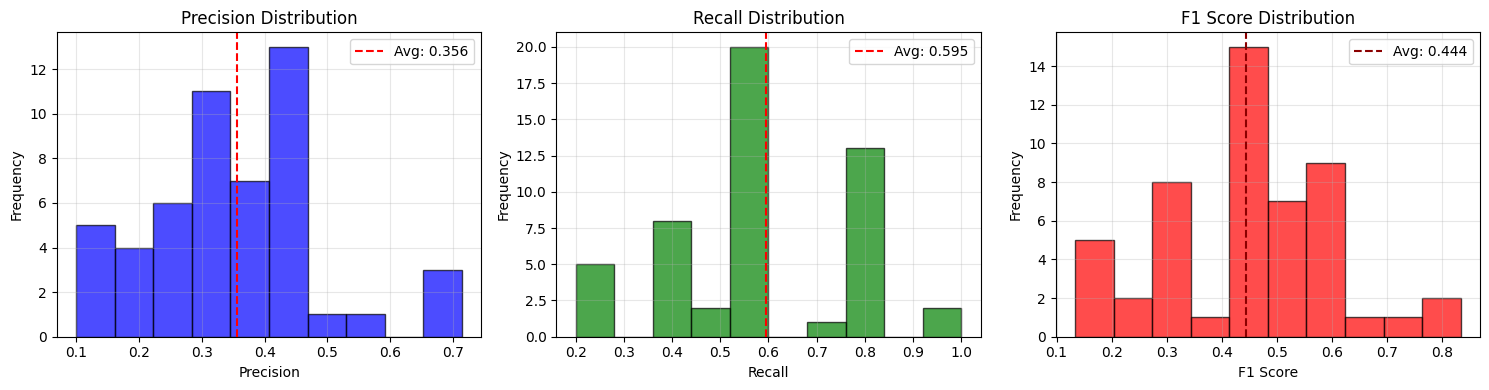

üìà Evaluation complete! Your RAG system achieved:
   ‚Ä¢ Precision: 35.6%
   ‚Ä¢ Recall: 59.5%
   ‚Ä¢ F1 Score: 44.4%

üìä Additional Statistics:
   ‚Ä¢ Best Precision: 0.714
   ‚Ä¢ Best Recall: 1.000
   ‚Ä¢ Best F1 Score: 0.833
   ‚Ä¢ Worst Precision: 0.100
   ‚Ä¢ Worst Recall: 0.200
   ‚Ä¢ Worst F1 Score: 0.133
   ‚Ä¢ Std Dev Precision: 0.136
   ‚Ä¢ Std Dev Recall: 0.198
   ‚Ä¢ Std Dev F1: 0.158


(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Precision Distribution'}, xlabel='Precision', ylabel='Frequency'>,
        <Axes: title={'center': 'Recall Distribution'}, xlabel='Recall', ylabel='Frequency'>,
        <Axes: title={'center': 'F1 Score Distribution'}, xlabel='F1 Score', ylabel='Frequency'>],
       dtype=object))

In [78]:
plot_rag_evaluation_results(openai_evaluation_results)

In [ ]:
# Run the evaluation
print("üöÄ Starting RAG Evaluation (Deterministic/Programmatic Approach)...")
voyage_evaluation_results = calculate_precision_recall_for_rag(
    evaluation_csv_path="rag_evaluation_dataset.csv",
    embedding_function=get_voyage_embedding,
)

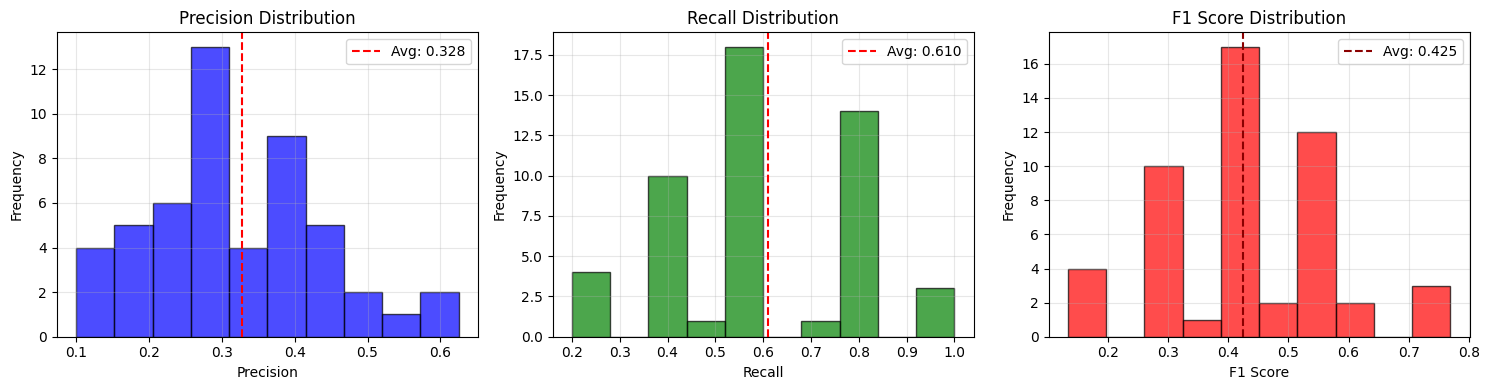

üìà Evaluation complete! Your RAG system achieved:
   ‚Ä¢ Precision: 32.8%
   ‚Ä¢ Recall: 61.0%
   ‚Ä¢ F1 Score: 42.5%

üìä Additional Statistics:
   ‚Ä¢ Best Precision: 0.625
   ‚Ä¢ Best Recall: 1.000
   ‚Ä¢ Best F1 Score: 0.769
   ‚Ä¢ Worst Precision: 0.100
   ‚Ä¢ Worst Recall: 0.200
   ‚Ä¢ Worst F1 Score: 0.133
   ‚Ä¢ Std Dev Precision: 0.118
   ‚Ä¢ Std Dev Recall: 0.201
   ‚Ä¢ Std Dev F1: 0.147


(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Precision Distribution'}, xlabel='Precision', ylabel='Frequency'>,
        <Axes: title={'center': 'Recall Distribution'}, xlabel='Recall', ylabel='Frequency'>,
        <Axes: title={'center': 'F1 Score Distribution'}, xlabel='F1 Score', ylabel='Frequency'>],
       dtype=object))

In [80]:
plot_rag_evaluation_results(voyage_evaluation_results)

## 2.4 Retrieval Augmented Generation

In [225]:
def generate_answer_from_search(
    user_query: str,
    model: str = "gpt-4.1",
    max_snippet_chars: int = 200,
    embedding_model_provider: str = "voyage",
    num_search_results: int = 5,
) -> str:
    """
    Use code search results as context to answer a user query via the OpenAI Response API.

    Args:
        search_results: List of dicts, each with keys:
            - file_name (str)
            - description (str)
            - content (str)
            - score (float)
        user_prompt: The user's question or instruction.
        model: OpenAI model to call (default "gpt-4.1").
        max_snippet_chars: How many chars of each file's content to include.

    Returns:
        The assistant's answer as a string.
    """

    # Let's get the search reults

    search_results = []

    if embedding_model_provider == "voyage":
        # Feel free to change the search result method to hybrid search
        search_results = semantic_search(
            user_query,
            db[CODEBASE_FILES],
            top_n=num_search_results,
            vector_search_index_name="vector_search_index_scalar_voyage",
            path="voyage_embeddings",
            embedding_function=get_voyage_embedding,
        )
    elif embedding_model_provider == "openai":
        search_results = semantic_search(
            user_query,
            db[CODEBASE_FILES],
            top_n=num_search_results,
            vector_search_index_name="vector_search_index_scalar_openai",
            path="openai_embeddings",
            embedding_function=get_openai_embedding,
        )

    # Build a contextual prompt
    context_entries = []
    for i, res in enumerate(search_results, start=1):
        fname = res.get("file_name", "")
        desc = res.get("description", "").strip()
        snippet = res.get("content", "").strip().replace("```", "`‚Äã``")
        snippet = snippet[:max_snippet_chars]
        context_entries.append(f"{i}. **{fname}** ‚Äî {desc}\n```{snippet}```")

    context_block = "\n\n".join(context_entries)

    prompt = (
        "You are a helpful assistant. Use the following code search results as context "
        "to answer the user query. Be precise and reference filenames when relevant.\n\n"
        f"### Context\n{context_block}\n\n"
        f"### User Query\n{user_query}\n\n"
        "### Answer\n"
    )

    # Call the Response API
    # response = openai_client.responses.create(model=model, input=prompt)

    response = openai_client.chat.completions.create(
        messages=[{"role": "user", "content": prompt}], model=model
    )

    # response.output_text.strip()
    return search_results, response.choices[0].message.content.strip()

In [226]:
user_query = "Get me the file responsibe for the defintion of the MemAgent class"

search_results, answer = generate_answer_from_search(
    user_query, embedding_model_provider="voyage"
)
print(answer)

The file responsible for the definition of the MemAgent class is memagent.py. This file implements a memory-based agent that interacts with language models, toolboxes, and personas to facilitate intelligent task execution.


In [227]:
search_results, answer = generate_answer_from_search(
    user_query, embedding_model_provider="openai"
)
print(answer)

The file responsible for the definition of the MemAgent class is **memagent.py**.

You can infer this from its filename and its imports, which include essential components like Toolbox, OpenAI, Persona, and MemoryComponent, indicating that it implements the core memory-based agent functionality.


## 2.5 ReRanking with VoyageAI (rerank-2)

In [228]:
from typing import Any, Dict, List


@log(span_type="retriever", name="rerank_search_results")
def rerank_search_results(
    search_results: List[Dict[str, Any]],
    user_query: str,
    model: str = "rerank-2",
    top_k: int = 5,
) -> List[Dict[str, Any]]:
    """
    Re-rank semantic search results using Voyage AI's rerank API.

    Args:
        search_results: List of dicts with at least a "description" field.
        user_query:     The original user query string.
        model:          The Voyage rerank model to use (e.g. "rerank-2").
        top_k:          If provided, limit to the top_k highest-scoring results.

    Returns:
        A new list of the original result dicts, each augmented with
        "rerank_score", sorted in descending order of that score.
    """

    # Extract the text snippets to rerank
    documents = [res["description"] for res in search_results]

    if top_k is None:
        top_k = len(documents)

    # Call the rerank endpoint
    resp = vo.rerank(user_query, documents, model=model, top_k=top_k)

    # Build a mapping from snippet ‚Üí score
    score_map = {r.document: r.relevance_score for r in resp.results}

    # Attach scores and sort
    reranked = []
    for orig in search_results:
        desc = orig.get("description")
        score = score_map.get(desc, 0.0)
        entry = orig.copy()
        entry["rerank_score"] = score
        reranked.append(entry)

    # Sort by new rerank_score descending
    reranked.sort(key=lambda x: x["rerank_score"], reverse=True)

    return reranked

In [229]:
def add_position_changes_to_rerank(
    original_results, reranked_results, identifier_field="file_name"
):
    """
    Add position change tracking to reranked search results.

    Args:
        original_results: Search results before reranking
        reranked_results: Search results after reranking
        identifier_field: Field to match documents (default: "file_name")

    Returns:
        Reranked results with added "change", "original_position", "new_position" fields
    """

    # Map each document to its original position
    original_positions = {
        result[identifier_field]: idx
        for idx, result in enumerate(original_results)
        if identifier_field in result
    }

    # Add position change info to each reranked result
    evaluated_results = []
    for new_idx, result in enumerate(reranked_results):
        eval_result = result.copy()
        identifier = result.get(identifier_field)

        if identifier and identifier in original_positions:
            original_idx = original_positions[identifier]
            position_change = original_idx - new_idx  # Positive = moved up

            eval_result["original_position"] = original_idx
            eval_result["new_position"] = new_idx
            eval_result["change"] = position_change
        else:
            eval_result["original_position"] = None
            eval_result["new_position"] = new_idx
            eval_result["change"] = None

        evaluated_results.append(eval_result)

    return evaluated_results


def print_position_changes(evaluated_results, top_n=10):
    """Print a summary of position changes from reranking."""

    print("üîÑ Reranking Position Changes")
    print("=" * 60)

    # Calculate statistics
    changes = [r["change"] for r in evaluated_results if r["change"] is not None]

    if not changes:
        print("‚ùå No position changes to analyze")
        return

    moved_up = sum(1 for c in changes if c > 0)
    moved_down = sum(1 for c in changes if c < 0)
    no_change = sum(1 for c in changes if c == 0)

    avg_up = sum(c for c in changes if c > 0) / moved_up if moved_up > 0 else 0
    avg_down = (
        abs(sum(c for c in changes if c < 0) / moved_down) if moved_down > 0 else 0
    )

    print("üìä Summary:")
    print(f"   üìà Moved Up:   {moved_up:3d} docs (avg: +{avg_up:.1f})")
    print(f"   üìâ Moved Down: {moved_down:3d} docs (avg: -{avg_down:.1f})")
    print(f"   ‚û°Ô∏è  No Change:  {no_change:3d} docs")

    print(f"\nüìã Top {min(top_n, len(evaluated_results))} After Reranking:")
    print("-" * 60)

    for i, result in enumerate(evaluated_results[:top_n]):
        change = result.get("change")
        original_pos = result.get("original_position")
        file_name = result.get("file_name", "Unknown")
        score = result.get("rerank_score", 0)

        # Format change indicator
        if change is None:
            change_str = "‚ùì"
        elif change > 0:
            change_str = f"‚¨ÜÔ∏è+{change}"
        elif change < 0:
            change_str = f"‚¨áÔ∏è{change}"
        else:
            change_str = "‚û°Ô∏è0"

        orig_str = f"#{original_pos+1}" if original_pos is not None else "?"

        print(
            f"{i+1:2d}. {file_name:<20} | {change_str:>6} | {score:.3f} | was {orig_str}"
        )

In [230]:
reranked_openai_results = rerank_search_results(
    hybrid_search_results_openai_embeddings, user_query, top_k=5
)

In [231]:
reranked_openai_results = add_position_changes_to_rerank(
    search_results_openai_embeddings, reranked_openai_results
)
print_position_changes(reranked_openai_results)

üîÑ Reranking Position Changes
üìä Summary:
   üìà Moved Up:     3 docs (avg: +1.7)
   üìâ Moved Down:   2 docs (avg: -2.5)
   ‚û°Ô∏è  No Change:    0 docs

üìã Top 5 After Reranking:
------------------------------------------------------------
 1. memagent.py          |   ‚¨ÜÔ∏è+1 | 0.641 | was #2
 2. summary_component.py |   ‚¨ÜÔ∏è+2 | 0.613 | was #4
 3. test_memagent_enhanced_tools.py |   ‚¨ÜÔ∏è+2 | 0.539 | was #5
 4. multi_agent_orchestrator.py |   ‚¨áÔ∏è-3 | 0.463 | was #1
 5. README.md            |   ‚¨áÔ∏è-2 | 0.439 | was #3


In [232]:
reranked_voyage_results = rerank_search_results(
    hybrid_search_results_voyage_embeddings, user_query, top_k=5
)

In [233]:
reranked_voyage_results = add_position_changes_to_rerank(
    search_results_voyageai_embeddings, reranked_voyage_results
)
print_position_changes(reranked_voyage_results)

üîÑ Reranking Position Changes
üìä Summary:
   üìà Moved Up:     1 docs (avg: +1.0)
   üìâ Moved Down:   1 docs (avg: -1.0)
   ‚û°Ô∏è  No Change:    3 docs

üìã Top 5 After Reranking:
------------------------------------------------------------
 1. memagent.py          |    ‚û°Ô∏è0 | 0.641 | was #1
 2. test_memagent_enhanced_tools.py |    ‚û°Ô∏è0 | 0.539 | was #2
 3. multi_agent_orchestrator.py |    ‚û°Ô∏è0 | 0.463 | was #3
 4. cwm.py               |   ‚¨ÜÔ∏è+1 | 0.436 | was #5
 5. evaluate_delegate_pattern.py |   ‚¨áÔ∏è-1 | 0.377 | was #4


## Why Domain‚ÄëSpecific Embeddings Can Outperform General‚ÄëPurpose Ones

1. **Syntax & Vocabulary Fit**  
   Domain models ‚Äúspeak code‚Äù‚Äîthey treat identifiers, decorators and type hints as meaningful signals rather than noise.

2. **Stronger Semantic Clustering**  
   Code‚Äëcentric embeddings group related functions, imports and idioms more tightly, so the most relevant files rise to the top.

3. **Score Thresholds & Latent‚ÄëSpace Concentration**  
   In a high‚Äëdimensional embedding space (e.g. 1,024‚Äì2,048‚ÄØdims), semantically similar code artifacts form tight clusters‚Äîprovided the model has been trained on code.  
   - **voyage‚Äëcode‚Äë3** dedicates its entire capacity to code patterns (imports, signatures, docstrings), so relevant files consistently score above common developer thresholds (0.7‚Äì0.8) when compared to general‚Äëpurpose embeddings.  
   - In our 52‚Äëquery benchmark:  
     - At a **0.8** cut‚Äëoff, the code‚Äëspecific model surfaces **3** high‚Äëconfidence files, whereas the general model surfaces **none**.  
     - Lowering to **0.7** yields **all 10** correct hits for voyage‚Äëcode‚Äë3 versus only **2** for the general model.  
   This demonstrates how domain‚Äëfocused embeddings amplify true positives above practical similarity thresholds.

4. **Reranking Stability**  
   After reranking, voyage‚Äëcode‚Äë3 results shifted minimally, indicating that its initial ranking was already aligned with true relevance. In contrast, the general‚Äëpurpose embedding required larger reshuffles:

---  
In practice, setting a threshold filters out noise while retaining high‚Äëconfidence matches. With voyage‚Äëcode‚Äë3, a 0.8 threshold would mean only truly relevant code files pass the cut, ensuring precision without sacrificing recall.  


In [234]:
# This will upload the trace to Galileo
galileo_context.flush()

# Part 3: Coding Agent

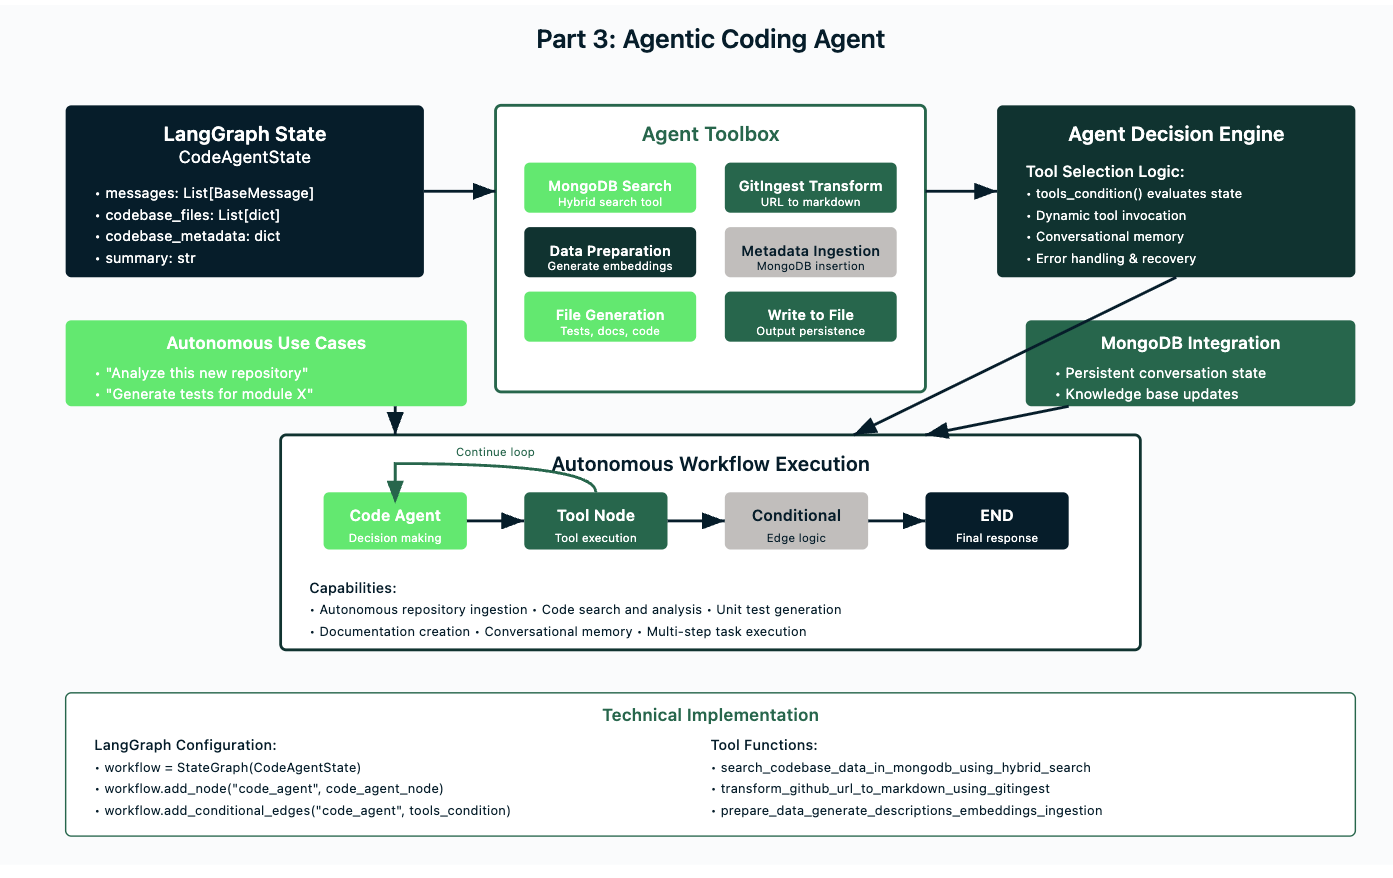

### 3.1 Create Agent State

In [174]:
import operator
from typing import Annotated, List, TypedDict

from langchain_core.messages import BaseMessage


class CodeAgentState(TypedDict):
    """State for the code agent."""

    messages: Annotated[List[BaseMessage], operator.add]
    codebase_files: List[dict]
    codebase_metadata: dict
    summary: str
    directory_tree: str
    content: str

### 3.2 Create Agent Tools

Create a tool that can transform github url to markdown content

In [176]:
# from langchain.agents import tool


@log(span_type="tool", name="transform_github_url_to_markdown_using_gitingest")
async def transform_github_url_to_markdown_using_gitingest(github_url: str) -> str:
    """
    Transform a github url into a markdown content.
    """

    summary, tree, content = await ingest_async(github_url)

    return summary, tree, content

Create tool that can prepare metadata for github repo

In [177]:
@log(span_type="tool", name="extract_github_metadata_for_ingestion")
def extract_github_metadata_for_ingestion(
    summary: str, directory_tree: str, content: str
) -> str:
    """
    Extract the metadata for ingestion from a github url.
    """

    attrs = {}
    codebase_metadata = {}
    for line in summary.splitlines():
        line = line.strip()
        if not line or ":" not in line:
            continue
        key, val = line.split(":", 1)
        attrs[key.lower().replace(" ", "_")] = val.strip()

    codebase_metadata["repository"] = attrs.get("repository")
    codebase_metadata["analyzed_count"] = attrs.get("files_analyzed")
    codebase_metadata["estimated_tokens"] = attrs.get("estimated_tokens")
    codebase_metadata["tree"] = directory_tree

    # Create the embeddings for the codebase_metadata using OpenAI and VoyageAI
    codebase_metadata["openai_embeddings"] = get_openai_embedding(
        codebase_metadata["description"]
    )
    codebase_metadata["voyage_embeddings"] = get_voyage_embedding(
        codebase_metadata["description"]
    )

    # generate_repo_description is a function created earlier in this notebook
    codebase_metadata["description"] = generate_repo_description(
        codebase_metadata, content
    )

    return codebase_metadata

Create a tool that can process the data for ingestion

In [178]:
@log(span_type="tool", name="prepare_data_generate_descriptions_embeddings_ingestion")
def prepare_data_generate_descriptions_embeddings_ingestion(content):
    """
    Prepare the data for ingestion into the database.
    """

    # From the markdown content, we will split the content into segments that represent files
    files = split_content_to_files(content)

    # Generate the descriptions for the each files
    for file in files:
        file["description"] = generate_file_description(file["content"])

        # Create the embeddings for the each files using OpenAI and VoyageAI
        file["openai_embeddings"] = get_openai_embedding(file["description"])
        file["voyage_embeddings"] = get_voyage_embedding(file["description"])

    return files

Ingest data into MongoDB

In [179]:
@log(span_type="tool", name="ingest_codebase_metadata_to_mongodb")
def ingest_codebase_metadata_to_mongodb(codebase_metadata: dict):
    """
    Ingest the codebase metadata into the database.
    """

    # Ensure that the collection exists, if not create it
    if CODEBASE_METADATA not in db.list_collection_names():
        db.create_collection(CODEBASE_METADATA)

    # Insert the codebase metadata documents into the collection
    db[CODEBASE_METADATA].insert_many(codebase_metadata)

    return "Codebase metadata ingested successfully"

In [180]:
@log(span_type="tool", name="ingest_codebase_files_metadata_to_mongodb")
def ingest_codebase_files_metadata_to_mongodb(codebase_files: dict):
    """
    Ingest the codebase files metadata into the database.
    """

    # Ensure that the collection exists, if not create it
    if CODEBASE_FILES not in db.list_collection_names():
        db.create_collection(CODEBASE_FILES)

    # Insert the codebase files documents into the collection
    db[CODEBASE_FILES].insert_many(codebase_files)

    return "Codebase metadata ingested successfully"

In [181]:
@log(span_type="tool", name="search_codebase_data_in_mongodb_using_hybrid_search")
def search_codebase_data_in_mongodb_using_hybrid_search(
    user_query: str, top_n: int = 3
):
    """
    Search the codebase using hybrid search.
    """

    hybrid_search_results = hybrid_search(
        user_query,
        db[CODEBASE_FILES],
        top_n=top_n,
        vector_weight=0.5,
        text_weight=0.5,
        vector_search_index_name="vector_search_index_scalar_voyage",
        text_search_index_name="codebase_files_index",
        embedding_path="voyage_embeddings",
        text_path="content",
        embedding_function=get_voyage_embedding,
    )

    return hybrid_search_results

In [182]:
from pathlib import Path
from typing import Optional, Union


@log(span_type="tool", name="write_to_file")
def write_to_file(
    content: str,
    filename: str,
    extension: str,
    directory: Optional[Union[str, Path]] = None,
) -> Path:
    """
    Write the given content to a file with the specified extension.

    Args:
        content (str): The text content to write into the file.
        filename (str): The base name of the file (without extension).
        extension (str): File extension, with or without leading dot (e.g., 'txt' or '.md').
        directory (Union[str, Path], optional): Target directory to save the file.
            Defaults to current working directory.

    Returns:
        Path: The full path to the written file.
    """
    # Ensure extension starts with a dot
    ext = extension if extension.startswith(".") else f".{extension}"

    # Determine and create target directory
    target_dir = Path(directory) if directory else Path.cwd()
    target_dir.mkdir(parents=True, exist_ok=True)

    # Construct full file path
    file_path = target_dir / f"{filename}{ext}"

    # Write content to the file
    with file_path.open(mode="w", encoding="utf-8") as file:
        file.write(content)

    return file_path

In [183]:
from langchain.tools.base import StructuredTool

code_agent_toolbox = [
    StructuredTool.from_function(search_codebase_data_in_mongodb_using_hybrid_search),
    StructuredTool.from_function(ingest_codebase_files_metadata_to_mongodb),
    StructuredTool.from_function(ingest_codebase_metadata_to_mongodb),
    StructuredTool.from_function(
        prepare_data_generate_descriptions_embeddings_ingestion
    ),
    StructuredTool.from_function(extract_github_metadata_for_ingestion),
    StructuredTool.from_function(transform_github_url_to_markdown_using_gitingest),
    StructuredTool.from_function(write_to_file),
]

### 3.3 LLM defintion

In [184]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1-mini")

In [186]:
code_agent = llm.bind_tools(code_agent_toolbox)

In [187]:
import re


def sanitize_name(name: str) -> str:
    """Sanitize the name to match OpenAI's pattern requirements."""
    # Remove any spaces, <, |, \, /, and >
    sanitized = re.sub(r"[\s<|\\/>]", "_", name)
    # Ensure the name isn't empty
    return sanitized or "anonymous"

### 3.4 Agent Node definition

In [188]:
import functools

from langchain_core.messages import AIMessage, ToolMessage


def agent_node(state, agent, name):
    # Extract just the messages from the state to pass to the agent
    messages = state["messages"]

    # Ensure all message names are properly sanitized before sending to the agent
    for msg in messages:
        if hasattr(msg, "name"):
            msg.name = sanitize_name(msg.name or "anonymous")

    result = agent.invoke(messages)

    if isinstance(result, ToolMessage):
        # Sanitize tool message name
        result.name = sanitize_name(result.name)
    else:
        # Use a fixed, compliant name for the AI
        result = AIMessage(
            **result.model_dump(exclude={"type", "name"}), name="assistant"
        )

    return {
        "messages": [result],
        "sender": sanitize_name(name),
    }

### 3.5 Tool Node Definition

In [189]:
from langgraph.prebuilt import ToolNode

code_agent_node = functools.partial(agent_node, agent=code_agent, name="Code Agent")
tool_node = ToolNode(code_agent_toolbox, name="tools")

### 3.6 Graph Definition

In [190]:
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(CodeAgentState)

workflow.add_node("code_agent", code_agent_node)
workflow.add_node("tools", tool_node)

workflow.set_entry_point("code_agent")
workflow.add_conditional_edges(
    "code_agent", tools_condition, {"tools": "tools", END: END}
)

workflow.add_edge("tools", "code_agent")

### 3.7 Adding Checkpointer

In [191]:
from langgraph.checkpoint.mongodb import AsyncMongoDBSaver
from pymongo import AsyncMongoClient

async_mongodb_client = AsyncMongoClient(os.getenv("MONGODB_URI"))
mongodb_checkpointer = AsyncMongoDBSaver(async_mongodb_client)

graph = workflow.compile(checkpointer=mongodb_checkpointer)

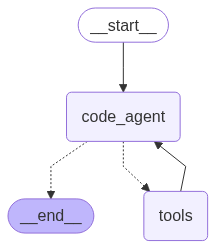

In [192]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [193]:
import asyncio

from langchain_core.messages import AIMessage, HumanMessage


@log(span_type="workflow", name="coding_agent")
async def chat_loop():
    config = {"configurable": {"thread_id": "01"}}

    while True:
        user_input = await asyncio.get_event_loop().run_in_executor(
            None, input, "User: "
        )
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Use a sanitized name for the human
        state = {"messages": [HumanMessage(content=user_input, name="human")]}

        print("Assistant: ", end="", flush=True)

        max_retries = 3
        retry_delay = 1

        for attempt in range(max_retries):
            try:
                async for chunk in graph.astream(state, config, stream_mode="values"):
                    if chunk.get("messages"):
                        last_message = chunk["messages"][-1]
                        if isinstance(last_message, AIMessage):
                            # Ensure the AI name is properly sanitized
                            last_message.name = "assistant"
                            print(last_message.content, end="", flush=True)
                        elif isinstance(last_message, ToolMessage):
                            # Sanitize tool names as well
                            tool_name = sanitize_name(last_message.name)
                            print(f"\n[Tool Used: {tool_name}]")
                            print(f"Tool Call ID: {last_message.tool_call_id}")
                            print(f"Content: {last_message.content}")
                            print("Assistant: ", end="", flush=True)
                break
            except Exception as e:
                if attempt < max_retries - 1:
                    print(f"\nAn unexpected error occurred: {e!s}")
                    print(f"\nRetrying in {retry_delay} seconds...")
                    await asyncio.sleep(retry_delay)
                    retry_delay *= 2
                else:
                    print(f"\nMax retries reached. Error: {e!s}")
                    break

        print("\n")  # New line after the complete response

### 3.8 Executing the Coding Chat Agent

In [194]:
# Ignore pydantic warnings
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

In [ ]:
# For Jupyter notebooks and IPython environments
import nest_asyncio

nest_asyncio.apply()

# Run the async function
await chat_loop()